In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.python.keras.utils.np_utils import to_categorical
# import tensorflow.keras.backend as K
from keras import backend as K

import SimpleITK as sitk
import scipy.misc
import scipy.ndimage
# from scipy.ndimage import zoom
import os
import numpy as np
import nibabel as nib
import scipy.ndimage.measurements as measure
import matplotlib.pyplot as plt
import re
import shutil
from tqdm import tqdm
from sklearn.utils import shuffle
import gc

In [57]:
########## step0 preprocessing ##########

def load_nii(filename):
    # Reads the image using SimpleITK
    itkimage = sitk.ReadImage(filename)
    #    print(itkimage)
    #    print(itkimage.GetPixelIDTypeAsString())
    #    print(itkimage.GetSize())
    #    print(itkimage.GetOrigin())
    #    print( itkimage.GetSpacing())
    #    print( itkimage.GetDirection())
    #    print( itkimage.GetNumberOfComponentsPerPixel())

    # Convert the image to a  numpy array
    np_img = sitk.GetArrayFromImage(itkimage)
    print('numpy image shape: ', np.shape(np_img), np.min(np_img), np.max(np_img))
    #
    # np_img[np_img==np.min(np_img)] = np.median(np_img)
    # np_img[np_img<=0] = np.median(np_img)
    # np_img = (np_img - np.min(np_img)) / (np.max(np_img) - np.min(np_img)) * 255
    # np_img[np_img < 60] = 60
    # np_img = np.array(np_img, dtype=np.int8)
    print('numpy image shape: ', np.shape(np_img), np.min(np_img), np.max(np_img))

    return np_img, itkimage


def save_nii(filename, data, itkimage, new_spacing):
    dataITK = sitk.GetImageFromArray(data)

    dataITK.SetSpacing(new_spacing)
    dataITK.SetDirection(itkimage.GetDirection())
    dataITK.SetOrigin(itkimage.GetOrigin())
    #    print(dataITK.GetPixelIDTypeAsString())

    sitk.WriteImage(dataITK, filename)


def resample(image, itkimage, new_spacing=[0.35, 0.35, 0.35]):
    # Determine current pixel spacing
    spacing = np.array(itkimage.GetSpacing(), dtype=np.float)

    ### for chile data ################################
    spacing = [spacing[0], spacing[0], spacing[0]]
    ###########################################################################

    print(spacing)
    # print(itkimage)

    resize_factor = np.flip(spacing / np.array(new_spacing, dtype=np.float), 0)

    print(resize_factor)

    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor

    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, order=3, mode='nearest')

    return image


def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]


def HistogramEqualization(img):
    img = img.astype(np.int)

    image = (img - np.min(img)) / (np.max(img) - np.min(img)) * 255
    image_int = image.astype(np.int)

    hist, bins = np.histogram(image_int.flatten(), 256, [0, 256])
    cdf = hist.cumsum()
    cdf_normalized = cdf * hist.max() / cdf.max()

    array = cdf_normalized

    value1 = 0.01 * cdf_normalized[255]
    aa1 = find_nearest(array, value1)
    bb1 = np.where(cdf_normalized == aa1)
    print(bb1[0][0])

    # value2 = 1 * cdf_normalized[255]
    value2 = 0.999 * cdf_normalized[255]
    aa2 = find_nearest(array, value2)
    bb2 = np.where(cdf_normalized == aa2)
    print(bb2[0][0])

    image_norm = image_int.copy()
    image_norm[image_norm < bb1[0][0]] = bb1[0][0]
    image_norm[image_norm > bb2[0][0]] = bb2[0][0]
    image_norm = ((image_norm - np.min(image_norm)) / (np.max(image_norm) - np.min(image_norm))) * 255
    image_norm_int = image_norm.astype(np.int)

    return image_norm_int


INPUT_FOLDER = '../data/step0/'
patients = os.listdir(INPUT_FOLDER)
print(patients)
patients.sort()
new_spacing = [0.35, 0.35, 0.35]
for patient in patients:
    filename = INPUT_FOLDER + patient
    print(filename)
    # np_img, itkimage = load_nii(filename)
    np_img = nib.load(filename).get_data()
    # np_img = np.transpose(np_img, (2, 1, 0))
    np_img[np_img==np.min(np_img)] = np.median(np_img)
    # resized = resample(np_img, itkimage, new_spacing)
    # print(np.shape(resized))

    ## Histogram Equalization
    image_norm_int = HistogramEqualization(np_img)
    # image_norm_int = np_img
    # image_norm_int = HistogramEqualization(resized)
    output = filename.replace('_image_standard', '')
    output = output.replace('step0', 'step1')
    print(output)
    # save_nii(output, image_norm_int, itkimage, new_spacing)
    npy = image_norm_int
    new_image = nib.Nifti1Image(npy, np.eye(4))
    new_image.set_data_dtype(np.uint8)
    nib.save(new_image, output)

['ANSYS_UNIGE_09_image.nii.gz', 'ANSYS_UNIGE_28_image.nii.gz']
../data/step0/ANSYS_UNIGE_09_image.nii.gz


C:\Users\19002\AppData\Local\Temp/ipykernel_17376/3204583298.py:112: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  np_img = nib.load(filename).get_data()


123
206
../data/step1/ANSYS_UNIGE_09_image.nii.gz
../data/step0/ANSYS_UNIGE_28_image.nii.gz
30
109
../data/step1/ANSYS_UNIGE_28_image.nii.gz


---  new folder --- ../data/step2/dome/
---  new folder --- ../data/step2/vessel/
['ANSYS_UNIGE_09_image.nii.gz', 'ANSYS_UNIGE_28_image.nii.gz'] 2
0 ANSYS_UNIGE_09_image ==========================Start==========================
(257, 257, 256)


C:\Users\19002\AppData\Local\Temp/ipykernel_17376/1027339615.py:38: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  image = nib.load(path + name + '.nii.gz').get_data()


0
251
64/64 [==============================] - 18s 272ms/step
2
[306, 357]
ANSYS_UNIGE_09_image ==========================infetence stage 1 finish==========================
1 ANSYS_UNIGE_28_image ==========================Start==========================
(257, 257, 256)


C:\Users\19002\AppData\Local\Temp/ipykernel_17376/1027339615.py:38: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  image = nib.load(path + name + '.nii.gz').get_data()


0
251
64/64 [==============================] - 18s 266ms/step
1
[1038]
ANSYS_UNIGE_28_image ==========================infetence stage 1 finish==========================


  0%|                                                                                            | 0/2 [00:00<?, ?it/s]C:\Users\19002\AppData\Local\Temp/ipykernel_17376/1027339615.py:1759: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  dome = nib.load(pred_aneurysm_path + pred_aneurysm_name).get_data()
 50%|██████████████████████████████████████████                                          | 1/2 [00:00<00:00,  1.07it/s]C:\Users\19002\AppData\Local\Temp/ipykernel_17376/1027339615.py:1759: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class

---  new folder --- ../results/dome/
3
ANSYS_UNIGE_09_image-1_center_42-151-123
ANSYS_UNIGE_09_image-1_center_42-151-123
['42', '151', '123']
42 151 123
ANSYS_UNIGE_09_image
(257, 257, 256) 255
cropSize 32
area1 shape : (64, 64, 64)


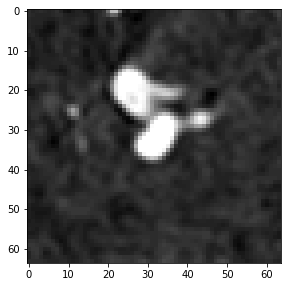

0 ANSYS_UNIGE_09_image ==========================Start==========================
1/1 [==============================] - 1s 1s/step
domeResult1 (64, 64, 64)
vesselResult (64, 64, 64)


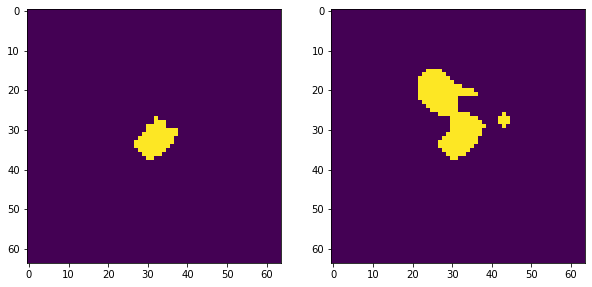

savename ANSYS_UNIGE_09_image-1_center_42-151-123
n_cc =  1   ExcludeNearTheEdge
28 to 36
27 to 37
27 to 37


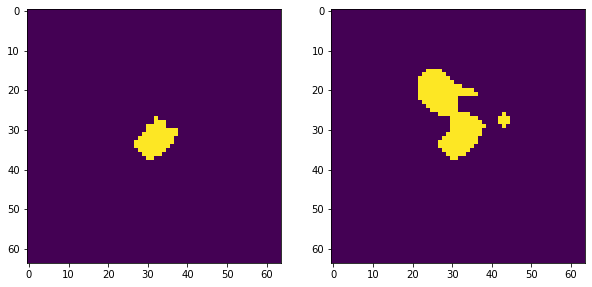

ANSYS_UNIGE_09_image ==========================finished==========================
ANSYS_UNIGE_09_image-2_center_138-124-138
ANSYS_UNIGE_09_image-2_center_138-124-138
['138', '124', '138']
138 124 138
ANSYS_UNIGE_09_image
(257, 257, 256) 255


C:\Users\19002\AppData\Local\Temp/ipykernel_17376/1027339615.py:1593: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  image = nib.load(datapath + name + '.nii.gz').get_data()


cropSize 32
area1 shape : (64, 64, 64)


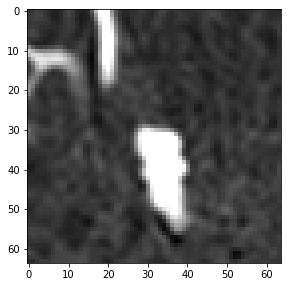

1 ANSYS_UNIGE_09_image ==========================Start==========================
1/1 [==============================] - 1s 1s/step
domeResult1 (64, 64, 64)
vesselResult (64, 64, 64)


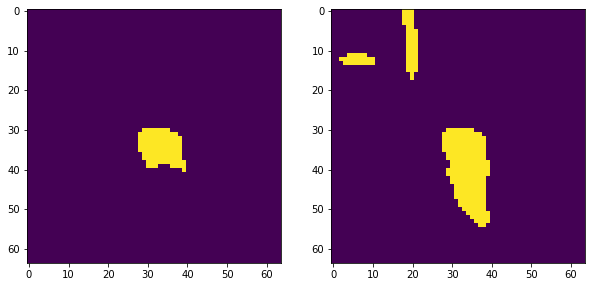

savename ANSYS_UNIGE_09_image-2_center_138-124-138
n_cc =  1   ExcludeNearTheEdge
28 to 37
30 to 41
28 to 39


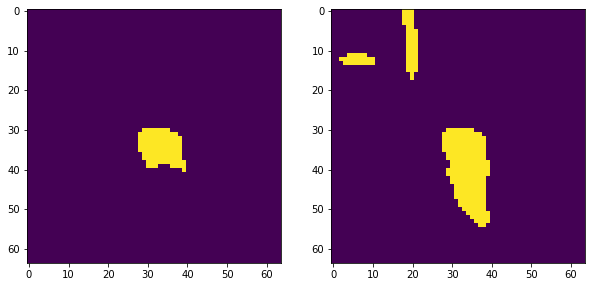

ANSYS_UNIGE_09_image ==========================finished==========================
ANSYS_UNIGE_28_image-1_center_121-73-84
ANSYS_UNIGE_28_image-1_center_121-73-84
['121', '73', '84']
121 73 84
ANSYS_UNIGE_28_image
(257, 257, 256) 255


C:\Users\19002\AppData\Local\Temp/ipykernel_17376/1027339615.py:1593: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  image = nib.load(datapath + name + '.nii.gz').get_data()


cropSize 32
area1 shape : (64, 64, 64)


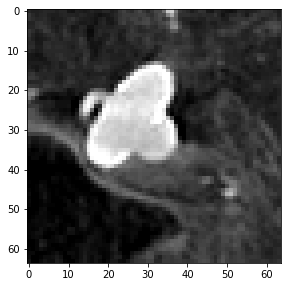

2 ANSYS_UNIGE_28_image ==========================Start==========================
1/1 [==============================] - 1s 1s/step
domeResult1 (64, 64, 64)
vesselResult (64, 64, 64)


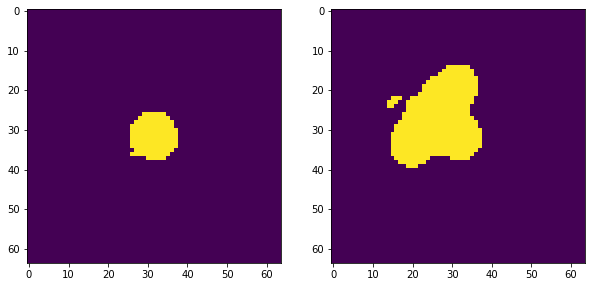

savename ANSYS_UNIGE_28_image-1_center_121-73-84
n_cc =  1   ExcludeNearTheEdge
26 to 42
25 to 39
25 to 37


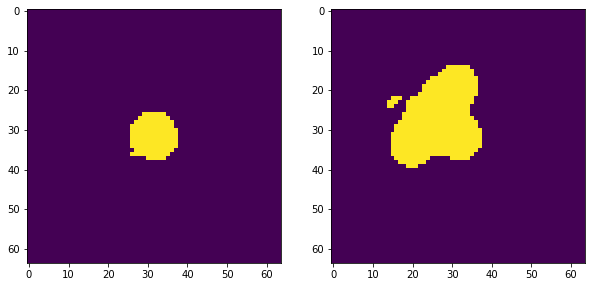

ANSYS_UNIGE_28_image ==========================finished==========================
0 ANSYS_UNIGE_09_image
(257, 257, 256) 255
(257, 257, 256) 0.0


C:\Users\19002\AppData\Local\Temp/ipykernel_17376/1027339615.py:1811: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  domelabel = nib.load(path + orgname).get_data()


1 ANSYS_UNIGE_28_image
(257, 257, 256) 255
(257, 257, 256) 0.0
ANSYS_UNIGE_09_image-1_center_42-151-123_dome_360.0.nii.gz
ANSYS_UNIGE_09_image
ANSYS_UNIGE_09_image.nii.gz
(257, 257, 256) 0
(64, 64, 64) 360.00002129003406
42 151 123
(321, 321, 320) 0.0
(257, 257, 256) 360.0


C:\Users\19002\AppData\Local\Temp/ipykernel_17376/1027339615.py:1667: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  dome_container = nib.load('../results/aneurysm/'+realname).get_data()
C:\Users\19002\AppData\Local\Temp/ipykernel_17376/1027339615.py:1671: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  dome_pred = nib.load('../results/dome/'+patches[i]).get_data()


1
[360]
ANSYS_UNIGE_09_image-2_center_138-124-138_dome_633.0.nii.gz
ANSYS_UNIGE_09_image
ANSYS_UNIGE_09_image-[360].nii.gz
(257, 257, 256) 360.00002129003406
(64, 64, 64) 633.0000374349765
138 124 138
(321, 321, 320) 1.0000000591389835
(257, 257, 256) 993.0


C:\Users\19002\AppData\Local\Temp/ipykernel_17376/1027339615.py:1667: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  dome_container = nib.load('../results/aneurysm/'+realname).get_data()
C:\Users\19002\AppData\Local\Temp/ipykernel_17376/1027339615.py:1671: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  dome_pred = nib.load('../results/dome/'+patches[i]).get_data()


2
[360, 633]
ANSYS_UNIGE_28_image-1_center_121-73-84_dome_1540.0.nii.gz
ANSYS_UNIGE_28_image
ANSYS_UNIGE_28_image.nii.gz
(257, 257, 256) 0
(64, 64, 64) 1540.0000910740346
121 73 84
(321, 321, 320) 0.0
(257, 257, 256) 1540.0


C:\Users\19002\AppData\Local\Temp/ipykernel_17376/1027339615.py:1667: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  dome_container = nib.load('../results/aneurysm/'+realname).get_data()
C:\Users\19002\AppData\Local\Temp/ipykernel_17376/1027339615.py:1671: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  dome_pred = nib.load('../results/dome/'+patches[i]).get_data()


1
[1540]


In [54]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def HistogramEqualization(img):

    image = (img-np.min(img))/(np.max(img)- np.min(img)) * 255
    image_int = image.astype(np.int)

    hist,bins = np.histogram(image_int.flatten(),256,[0,256])
    cdf = hist.cumsum()
    cdf_normalized = cdf * hist.max()/ cdf.max()

    array = cdf_normalized

    value1 = 0.01*cdf_normalized[255]
    aa1 = find_nearest(array, value1)
    bb1 = np.where(cdf_normalized==aa1)
    print(bb1[0][0])

    value2 = 0.999*cdf_normalized[255]
    aa2 = find_nearest(array, value2)
    bb2 = np.where(cdf_normalized==aa2)
    print(bb2[0][0])

    image_norm = image_int.copy()
    image_norm[image_norm<bb1[0][0]]=bb1[0][0]
    image_norm[image_norm>bb2[0][0]]=bb2[0][0]
    image_norm = ((image_norm - np.min(image_norm)) / (np.max(image_norm) - np.min(image_norm)) ) *255
    image_norm_int = image_norm.astype(np.int)
    
    return image_norm_int

def preprocess(name):
    name = name
    path = '../data/step1/'
    image = nib.load(path + name + '.nii.gz').get_data()
    
#     tar = tarfile.open(path+name+".tar.gz", "r:gz")
#     for member in tar.getmembers():
#          f = tar.extractfile(member)
#          if f is not None:
#              image = f.read()
    
    print(np.shape(image))
    # image normalization & concatnate image and label
    
    
    image = HistogramEqualization(image)
    image_norm = (image - np.min(image)) / (np.max(image) - np.min(image))
    # image_norm = image_norm[:, :, :, np.newaxis]
    x_bias = np.shape(image_norm)[0] % 64
    y_bias = np.shape(image_norm)[1] % 64
    z_bias = np.shape(image_norm)[2] % 64
    
    x_bias_add = 0
    y_bias_add = 0
    z_bias_add = 0
    
    if x_bias < 16:
        x_bias_add = 1
        image_new1 = np.zeros(shape=(np.shape(image_norm)[0]+16, np.shape(image_norm)[1], np.shape(image_norm)[2]))
        image_new1[:] = np.median(image_norm)
        image_new1[:-16,:,:] = image_norm                   
    if y_bias < 16:
        y_bias_add = 1
        image_new2 = np.zeros(shape=(np.shape(image_new1)[0], np.shape(image_new1)[1]+16, np.shape(image_new1)[2]))
        image_new2[:] = np.median(image_norm)
        image_new2[:,:-16,:] = image_new1
    if z_bias < 16:
        z_bias_add = 1
        image_new3 = np.zeros(shape=(np.shape(image_new2)[0], np.shape(image_new2)[1], np.shape(image_new2)[2]+16))
        image_new3[:] = np.median(image_norm)
        image_new3[:,:,:-16] = image_new2
    
    image = image_new3
    image_norm = (image - np.min(image)) / (np.max(image) - np.min(image))
    image_norm = image_norm[:, :, :, np.newaxis]
    x_bias = np.shape(image_norm)[0] % 64
    y_bias = np.shape(image_norm)[1] % 64
    z_bias = np.shape(image_norm)[2] % 64
                              
    aa = np.shape(image_norm)[0] // 64
    bb = np.shape(image_norm)[1] // 64
    cc = np.shape(image_norm)[2] // 64
    all_patch_000 = []
    for a in range(aa):
        for b in range(bb):
            for c in range(cc):
                patch = image_norm[64 * a:64 * (a + 1), 64 * b:64 * (b + 1), 64 * c:64 * (c + 1)]
                all_patch_000.append(patch)
    # a+bias
    all_patch_100 = []
    for a in range(aa):
        for b in range(bb):
            for c in range(cc):
                patch = image_norm[x_bias + 64 * a:x_bias + 64 * (a + 1), 64 * b:64 * (b + 1), 64 * c:64 * (c + 1)]
                all_patch_100.append(patch)
    # b+bias
    all_patch_010 = []
    for a in range(aa):
        for b in range(bb):
            for c in range(cc):
                patch = image_norm[64 * a:64 * (a + 1), y_bias + 64 * b:y_bias + 64 * (b + 1), 64 * c:64 * (c + 1)]
                all_patch_010.append(patch)
    # c+bias
    all_patch_001 = []
    for a in range(aa):
        for b in range(bb):
            for c in range(cc):
                patch = image_norm[64 * a:64 * (a + 1), 64 * b:64 * (b + 1), z_bias + 64 * c:z_bias + 64 * (c + 1)]
                all_patch_001.append(patch)
    # ab+bias
    all_patch_110 = []
    for a in range(aa):
        for b in range(bb):
            for c in range(cc):
                patch = image_norm[x_bias + 64 * a:x_bias + 64 * (a + 1), y_bias + 64 * b:y_bias + 64 * (b + 1),
                        64 * c:64 * (c + 1)]
                all_patch_110.append(patch)
    # ac+bias
    all_patch_101 = []
    for a in range(aa):
        for b in range(bb):
            for c in range(cc):
                patch = image_norm[x_bias + 64 * a:x_bias + 64 * (a + 1), 64 * b:64 * (b + 1),
                        z_bias + 64 * c:z_bias + 64 * (c + 1)]
                all_patch_101.append(patch)
    # bc+bias
    all_patch_011 = []
    for a in range(aa):
        for b in range(bb):
            for c in range(cc):
                patch = image_norm[64 * a:64 * (a + 1), y_bias + 64 * b:y_bias + 64 * (b + 1),
                        z_bias + 64 * c:z_bias + 64 * (c + 1)]
                all_patch_011.append(patch)
    # bc+bias
    all_patch_111 = []
    for a in range(aa):
        for b in range(bb):
            for c in range(cc):
                patch = image_norm[x_bias + 64 * a:x_bias + 64 * (a + 1), y_bias + 64 * b:y_bias + 64 * (b + 1),
                        z_bias + 64 * c:z_bias + 64 * (c + 1)]
                all_patch_111.append(patch)
    all_patch = []
    all_patch = np.concatenate([all_patch_000,
                                all_patch_100, all_patch_010, all_patch_001,
                                all_patch_110, all_patch_101, all_patch_011,
                                all_patch_111], axis=0)
    if x_bias > 32 or y_bias > 32 or z_bias > 32:

        dadada = 0
    else:
        dadada = 1
    # judge if we need to test twice
    # if x_bias > 32 or y_bias > 32 or z_bias > 32:
    
#     if x_bias<16 or y_bias<16 or z_bias<16:
#         twice = True
#         x_bias2 = x_bias // 2
#         y_bias2 = y_bias // 2
#         z_bias2 = z_bias // 2
        
        
#         all_patch_000 = []
#         for a in range(aa):
#             for b in range(bb):
#                 for c in range(cc):
#                     patch = image_norm[64 * a:64 * (a + 1), 64 * b:64 * (b + 1), 64 * c:64 * (c + 1)]
#                     all_patch_000.append(patch)
#         # a+bias
#         all_patch_100 = []
#         for a in range(aa):
#             for b in range(bb):
#                 for c in range(cc):
#                     patch = image_norm[x_bias2 + 64 * a:x_bias2 + 64 * (a + 1), 64 * b:64 * (b + 1),
#                             64 * c:64 * (c + 1)]
#                     all_patch_100.append(patch)
#         # b+bias
#         all_patch_010 = []
#         for a in range(aa):
#             for b in range(bb):
#                 for c in range(cc):
#                     patch = image_norm[64 * a:64 * (a + 1), y_bias2 + 64 * b:y_bias2 + 64 * (b + 1),
#                             64 * c:64 * (c + 1)]
#                     all_patch_010.append(patch)
#         # c+bias
#         all_patch_001 = []
#         for a in range(aa):
#             for b in range(bb):
#                 for c in range(cc):
#                     patch = image_norm[64 * a:64 * (a + 1), 64 * b:64 * (b + 1),
#                             z_bias2 + 64 * c:z_bias2 + 64 * (c + 1)]
#                     all_patch_001.append(patch)
#         # ab+bias
#         all_patch_110 = []
#         for a in range(aa):
#             for b in range(bb):
#                 for c in range(cc):
#                     patch = image_norm[x_bias2 + 64 * a:x_bias2 + 64 * (a + 1), y_bias2 + 64 * b:y_bias2 + 64 * (b + 1),
#                             64 * c:64 * (c + 1)]
#                     all_patch_110.append(patch)
#         # ac+bias
#         all_patch_101 = []
#         for a in range(aa):
#             for b in range(bb):
#                 for c in range(cc):
#                     patch = image_norm[x_bias2 + 64 * a:x_bias2 + 64 * (a + 1), 64 * b:64 * (b + 1),
#                             z_bias2 + 64 * c:z_bias2 + 64 * (c + 1)]
#                     all_patch_101.append(patch)
#         # bc+bias
#         all_patch_011 = []
#         for a in range(aa):
#             for b in range(bb):
#                 for c in range(cc):
#                     patch = image_norm[64 * a:64 * (a + 1), y_bias2 + 64 * b:y_bias2 + 64 * (b + 1),
#                             z_bias2 + 64 * c:z_bias2 + 64 * (c + 1)]
#                     all_patch_011.append(patch)
#         # bc+bias
#         all_patch_111 = []
#         for a in range(aa):
#             for b in range(bb):
#                 for c in range(cc):
#                     patch = image_norm[x_bias2 + 64 * a:x_bias2 + 64 * (a + 1), y_bias2 + 64 * b:y_bias2 + 64 * (b + 1),
#                             z_bias2 + 64 * c:z_bias2 + 64 * (c + 1)]
#                     all_patch_111.append(patch)
#         all_patch2 = []
#         all_patch2 = np.concatenate([all_patch_000,
#                                      all_patch_100, all_patch_010, all_patch_001,
#                                      all_patch_110, all_patch_101, all_patch_011,
#                                      all_patch_111], axis=0)
        
        
        
    
    # if True:
    if x_bias > 32 or y_bias > 32 or z_bias > 32:
        twice = True
        x_bias2 = x_bias // 2
        # print('x_bias, x_bias2 aaaaaaaaaaaaaaaaaaaaaa',x_bias, x_bias2)
        y_bias2 = y_bias // 2
        z_bias2 = z_bias // 2
        
        
        all_patch_000 = []
        for a in range(aa):
            for b in range(bb):
                for c in range(cc):
                    patch = image_norm[64 * a:64 * (a + 1), 64 * b:64 * (b + 1), 64 * c:64 * (c + 1)]
                    all_patch_000.append(patch)
        # a+bias
        all_patch_100 = []
        for a in range(aa):
            for b in range(bb):
                for c in range(cc):
                    patch = image_norm[x_bias2 + 64 * a:x_bias2 + 64 * (a + 1), 64 * b:64 * (b + 1),
                            64 * c:64 * (c + 1)]
                    all_patch_100.append(patch)
        # b+bias
        all_patch_010 = []
        for a in range(aa):
            for b in range(bb):
                for c in range(cc):
                    patch = image_norm[64 * a:64 * (a + 1), y_bias2 + 64 * b:y_bias2 + 64 * (b + 1),
                            64 * c:64 * (c + 1)]
                    all_patch_010.append(patch)
        # c+bias
        all_patch_001 = []
        for a in range(aa):
            for b in range(bb):
                for c in range(cc):
                    patch = image_norm[64 * a:64 * (a + 1), 64 * b:64 * (b + 1),
                            z_bias2 + 64 * c:z_bias2 + 64 * (c + 1)]
                    all_patch_001.append(patch)
        # ab+bias
        all_patch_110 = []
        for a in range(aa):
            for b in range(bb):
                for c in range(cc):
                    patch = image_norm[x_bias2 + 64 * a:x_bias2 + 64 * (a + 1), y_bias2 + 64 * b:y_bias2 + 64 * (b + 1),
                            64 * c:64 * (c + 1)]
                    all_patch_110.append(patch)
        # ac+bias
        all_patch_101 = []
        for a in range(aa):
            for b in range(bb):
                for c in range(cc):
                    patch = image_norm[x_bias2 + 64 * a:x_bias2 + 64 * (a + 1), 64 * b:64 * (b + 1),
                            z_bias2 + 64 * c:z_bias2 + 64 * (c + 1)]
                    all_patch_101.append(patch)
        # bc+bias
        all_patch_011 = []
        for a in range(aa):
            for b in range(bb):
                for c in range(cc):
                    patch = image_norm[64 * a:64 * (a + 1), y_bias2 + 64 * b:y_bias2 + 64 * (b + 1),
                            z_bias2 + 64 * c:z_bias2 + 64 * (c + 1)]
                    all_patch_011.append(patch)
        # bc+bias
        all_patch_111 = []
        for a in range(aa):
            for b in range(bb):
                for c in range(cc):
                    patch = image_norm[x_bias2 + 64 * a:x_bias2 + 64 * (a + 1), y_bias2 + 64 * b:y_bias2 + 64 * (b + 1),
                            z_bias2 + 64 * c:z_bias2 + 64 * (c + 1)]
                    all_patch_111.append(patch)
        all_patch2 = []
        all_patch2 = np.concatenate([all_patch_000,
                                     all_patch_100, all_patch_010, all_patch_001,
                                     all_patch_110, all_patch_101, all_patch_011,
                                     all_patch_111], axis=0)

    else:
        twice = False
        x_bias2 = x_bias // 2
        y_bias2 = y_bias // 2
        z_bias2 = z_bias // 2
        all_patch2 = []
    patch_size = np.shape(all_patch_111)[0]
    return twice, aa, bb, cc, patch_size, image, x_bias, y_bias, z_bias, x_bias2, y_bias2, z_bias2, all_patch, all_patch2, x_bias_add, y_bias_add, z_bias_add


def ATT256(acti5_2):
    # Attention

    b = Conv3D(filters=32, kernel_size=1, padding='same', use_bias=False, kernel_initializer='he_normal')(acti5_2)
    c = Conv3D(filters=32, kernel_size=1, padding='same', use_bias=False, kernel_initializer='he_normal')(acti5_2)
    d = Conv3D(filters=256, kernel_size=1, padding='same', use_bias=False, kernel_initializer='he_normal')(acti5_2)

    vec_b = Reshape((512, 32))(b)
    vec_cT = Reshape((512, 32))(c)
    vec_cT = Permute((2, 1))(vec_cT)
    bcT = Dot(axes=(1, 2))([vec_cT, vec_b])
    softmax_bcT = Activation('softmax')(bcT)
    vec_d = Reshape((512, 256))(d)
    bcTd = Dot(axes=(1, 2))([vec_d, softmax_bcT])

    bcTd = Reshape((8, 8, 8, 256))(bcTd)
    out1 = Add()([bcTd, acti5_2])
    pam = BatchNormalization()(out1)
    pam = Activation('relu')(pam)

    vec_a = Reshape((512, 256))(acti5_2)
    vec_aT = Permute((2, 1))(vec_a)
    aTa = Dot(axes=(1, 2))([vec_a, vec_aT])
    softmax_aTa = Activation('softmax')(aTa)
    aaTa = Dot(axes=(1, 2))([softmax_aTa, vec_a])
    aaTa = Reshape((8, 8, 8, 256))(aaTa)
    out2 = Add()([aaTa, acti5_2])
    cam = BatchNormalization()(out2)
    cam = Activation('relu')(cam)

    attention = Add()([pam, cam])

    return attention


def ATT(acti5_2):
    # Attention

    b = Conv3D(filters=32, kernel_size=1, padding='same', use_bias=False, kernel_initializer='he_normal')(acti5_2)
    c = Conv3D(filters=32, kernel_size=1, padding='same', use_bias=False, kernel_initializer='he_normal')(acti5_2)
    d = Conv3D(filters=128, kernel_size=1, padding='same', use_bias=False, kernel_initializer='he_normal')(acti5_2)

    vec_b = Reshape((512, 32))(b)
    vec_cT = Reshape((512, 32))(c)
    vec_cT = Permute((2, 1))(vec_cT)
    bcT = Dot(axes=(1, 2))([vec_cT, vec_b])
    softmax_bcT = Activation('softmax')(bcT)
    vec_d = Reshape((512, 128))(d)
    bcTd = Dot(axes=(1, 2))([vec_d, softmax_bcT])

    bcTd = Reshape((8, 8, 8, 128))(bcTd)
    out1 = Add()([bcTd, acti5_2])
    pam = BatchNormalization()(out1)
    pam = Activation('relu')(pam)

    vec_a = Reshape((512, 128))(acti5_2)
    vec_aT = Permute((2, 1))(vec_a)
    aTa = Dot(axes=(1, 2))([vec_a, vec_aT])
    softmax_aTa = Activation('softmax')(aTa)
    aaTa = Dot(axes=(1, 2))([softmax_aTa, vec_a])
    aaTa = Reshape((8, 8, 8, 128))(aaTa)
    out2 = Add()([aaTa, acti5_2])
    cam = BatchNormalization()(out2)
    cam = Activation('relu')(cam)

    attention = Add()([pam, cam])

    return attention


def reduction_block(x, filters):
    # 1
    conv1_1 = Conv3D(filters=filters, kernel_size=1, strides=2, padding='same',
                     kernel_initializer='he_normal')(x)
    norm1_1 = BatchNormalization()(conv1_1)
    acti1_1 = Activation('relu')(norm1_1)

    conv1_2 = Conv3D(filters=filters, kernel_size=(1, 1, 5), strides=1, padding='same',
                     kernel_initializer='he_normal')(acti1_1)
    norm1_2 = BatchNormalization()(conv1_2)
    acti1_2 = Activation('relu')(norm1_2)

    conv1_3 = Conv3D(filters=filters, kernel_size=(1, 5, 1), strides=1, padding='same',
                     kernel_initializer='he_normal')(acti1_2)
    norm1_3 = BatchNormalization()(conv1_3)
    acti1_3 = Activation('relu')(norm1_3)

    conv1_4 = Conv3D(filters=filters, kernel_size=(5, 1, 1), strides=1, padding='same',
                     kernel_initializer='he_normal')(acti1_3)
    norm1_4 = BatchNormalization()(conv1_4)
    acti1_4 = Activation('relu')(norm1_4)

    # 2
    maxpool2 = MaxPooling3D()(x)
    conv2_1 = Conv3D(filters=filters, kernel_size=1, strides=1, padding='same',
                     kernel_initializer='he_normal')(maxpool2)
    norm2_1 = BatchNormalization()(conv2_1)
    acti2_1 = Activation('relu')(norm2_1)

    # 3
    conv3_1 = Conv3D(filters=filters, kernel_size=1, strides=1, padding='same',
                     kernel_initializer='he_normal')(x)
    norm3_1 = BatchNormalization()(conv3_1)
    acti3_1 = Activation('relu')(norm3_1)

    conv3_2 = Conv3D(filters=filters, kernel_size=5, strides=2, padding='same',
                     kernel_initializer='he_normal')(acti3_1)
    norm3_2 = BatchNormalization()(conv3_2)
    acti3_2 = Activation('relu')(norm3_2)

    concat = Concatenate()([acti1_4, acti2_1, acti3_2])

    return concat


def deep_block(x, filters):
    # 1
    conv1_1 = Conv3D(filters=filters, kernel_size=1, strides=1, padding='same',
                     kernel_initializer='he_normal')(x)
    norm1_1 = BatchNormalization()(conv1_1)
    acti1_1 = Activation('relu')(norm1_1)

    conv1_2 = Conv3D(filters=filters, kernel_size=(1, 1, 7), strides=1, padding='same',
                     kernel_initializer='he_normal')(acti1_1)
    norm1_2 = BatchNormalization()(conv1_2)
    acti1_2 = Activation('relu')(norm1_2)

    conv1_3 = Conv3D(filters=filters, kernel_size=(1, 7, 1), strides=1, padding='same',
                     kernel_initializer='he_normal')(acti1_2)
    norm1_3 = BatchNormalization()(conv1_3)
    acti1_3 = Activation('relu')(norm1_3)

    conv1_4 = Conv3D(filters=filters, kernel_size=(7, 1, 1), strides=1, padding='same',
                     kernel_initializer='he_normal')(acti1_3)
    norm1_4 = BatchNormalization()(conv1_4)
    acti1_4 = Activation('relu')(norm1_4)

    # 2
    conv2_1 = Conv3D(filters=filters, kernel_size=1, strides=1, padding='same',
                     kernel_initializer='he_normal')(x)
    norm2_1 = BatchNormalization()(conv2_1)
    acti2_1 = Activation('relu')(norm2_1)

    conv2_2 = Conv3D(filters=filters, kernel_size=(7, 1, 1), strides=1, padding='same',
                     kernel_initializer='he_normal')(acti2_1)
    norm2_2 = BatchNormalization()(conv2_2)
    acti2_2 = Activation('relu')(norm2_2)

    conv2_3 = Conv3D(filters=filters, kernel_size=(1, 7, 1), strides=1, padding='same',
                     kernel_initializer='he_normal')(acti2_1)
    norm2_3 = BatchNormalization()(conv2_3)
    acti2_3 = Activation('relu')(norm2_3)

    conv2_4 = Conv3D(filters=filters, kernel_size=(1, 1, 7), strides=1, padding='same',
                     kernel_initializer='he_normal')(acti2_1)
    norm2_4 = BatchNormalization()(conv2_4)
    acti2_4 = Activation('relu')(norm2_4)

    # 3
    conv3_1 = Conv3D(filters=filters, kernel_size=1, strides=1, padding='same',
                     kernel_initializer='he_normal')(x)
    norm3_1 = BatchNormalization()(conv3_1)
    acti3_1 = Activation('relu')(norm3_1)

    conv3_2 = Conv3D(filters=filters, kernel_size=(5, 5, 5), strides=1, padding='same',
                     kernel_initializer='he_normal')(acti3_1)
    norm3_2 = BatchNormalization()(conv3_2)
    acti3_2 = Activation('relu')(norm3_2)

    concat = Concatenate()([acti1_4, acti2_2, acti2_3, acti2_4, acti3_2])

    return concat


def MultiView(x, filters):
    conv1_1 = Conv3D(filters=filters, kernel_size=3, strides=1, padding='same',
                     kernel_initializer='he_normal')(x)
    norm1_1 = BatchNormalization()(conv1_1)
    acti1_1 = Activation('relu')(norm1_1)

    conv2_1 = Conv3D(filters=filters, kernel_size=3, strides=1, padding='same',
                     kernel_initializer='he_normal')(x)
    norm2_1 = BatchNormalization()(conv2_1)
    acti2_1 = Activation('relu')(norm2_1)

    conv3_1 = Conv3D(filters=filters, kernel_size=3, strides=1, padding='same',
                     kernel_initializer='he_normal')(x)
    norm3_1 = BatchNormalization()(conv3_1)
    acti3_1 = Activation('relu')(norm3_1)

    #
    conv1_2 = Conv3D(filters=filters, kernel_size=(1, 3, 3), strides=1, padding='same',
                     kernel_initializer='he_normal')(acti1_1)
    norm1_2 = BatchNormalization()(conv1_2)
    acti1_2 = Activation('relu')(norm1_2)

    conv2_2 = Conv3D(filters=filters, kernel_size=(3, 1, 3), strides=1, padding='same',
                     kernel_initializer='he_normal')(acti2_1)
    norm2_2 = BatchNormalization()(conv2_2)
    acti2_2 = Activation('relu')(norm2_2)

    conv3_2 = Conv3D(filters=filters, kernel_size=(3, 3, 1), strides=1, padding='same',
                     kernel_initializer='he_normal')(acti3_1)
    norm3_2 = BatchNormalization()(conv3_2)
    acti3_2 = Activation('relu')(norm3_2)

    #
    add = Add()([acti1_2, acti2_2, acti3_2])
    conv = Conv3D(filters=filters, kernel_size=(1, 1, 1), strides=1, padding='same',
                  kernel_initializer='he_normal')(add)
    norm = BatchNormalization()(conv)
    acti = Activation('relu')(norm)

    return acti


class UNet3D:
    def __init__(self, inputshape=(64, 64, 64, 1), classes=3):
        self.input = Input(inputshape)
        self.classes = classes

    # All
    def get_model_6(self):

        # layer 1
        # bn0_1 = BatchNormalization()(self.input)
        conv1_1 = Conv3D(filters=16, kernel_size=3, strides=1, padding='same',
                         kernel_initializer='he_normal', name='conv1_1')(self.input)
        bn1_1 = BatchNormalization()(conv1_1)
        acti1_1 = Activation(activation='relu')(bn1_1)

        conv1_2 = Conv3D(filters=16, kernel_size=3, strides=1, padding='same',
                         kernel_initializer='he_normal', name='conv1_2')(acti1_1)
        bn1_2 = BatchNormalization()(conv1_2)
        acti1_2 = Activation(activation='relu')(bn1_2)

        multiview1 = MultiView(self.input, 16)
        add1 = Add()([acti1_2, multiview1])

        maxpool1 = reduction_block(add1, 16)

        # layer 2
        conv2_1 = Conv3D(filters=32, kernel_size=3, strides=1, padding='same',
                         kernel_initializer='he_normal', name='conv2_1')(maxpool1)
        bn2_1 = BatchNormalization()(conv2_1)
        acti2_1 = Activation(activation='relu')(bn2_1)

        conv2_2 = Conv3D(filters=32, kernel_size=3, strides=1, padding='same',
                         kernel_initializer='he_normal', name='conv2_2')(acti2_1)
        bn2_2 = BatchNormalization()(conv2_2)
        acti2_2 = Activation(activation='relu')(bn2_2)

        multiview2 = MultiView(maxpool1, 32)
        add2 = Add()([acti2_2, multiview2])

        maxpool2 = reduction_block(add2, 32)

        # layer 3
        conv3_1 = Conv3D(filters=64, kernel_size=3, strides=1, padding='same',
                         kernel_initializer='he_normal', name='conv3_1')(maxpool2)
        bn3_1 = BatchNormalization()(conv3_1)
        acti3_1 = Activation(activation='relu')(bn3_1)

        conv3_2 = Conv3D(filters=64, kernel_size=3, strides=1, padding='same',
                         kernel_initializer='he_normal', name='conv3_2')(acti3_1)
        bn3_2 = BatchNormalization()(conv3_2)
        acti3_2 = Activation(activation='relu')(bn3_2)

        multiview3 = MultiView(maxpool2, 64)
        add3 = Add()([acti3_2, multiview3])

        maxpool3 = reduction_block(add3, 64)

        # layer 4
        deep4 = deep_block(maxpool3, 128)

        conv4_1 = Conv3D(filters=128, kernel_size=3, strides=1, padding='same',
                         kernel_initializer='he_normal', name='conv4_1')(deep4)
        bn4_1 = BatchNormalization()(conv4_1)
        acti4_1 = Activation(activation='relu')(bn4_1)

        conv4_2 = Conv3D(filters=128, kernel_size=3, strides=1, padding='same',
                         kernel_initializer='he_normal', name='conv4_2')(acti4_1)
        bn4_2 = BatchNormalization()(conv4_2)
        acti4_2 = Activation(activation='relu')(bn4_2)

        multiview4 = MultiView(deep4, 128)
        add4 = Add()([acti4_2, multiview4])

        attention = ATT(add4)

        # layer12
        upsample12 = Conv3DTranspose(filters=16, kernel_size=3, strides=2, padding='same',
                                     kernel_initializer='he_normal')(add2)
        bn12 = BatchNormalization()(upsample12)
        acti12 = Activation(activation='relu')(bn12)

        concat12 = Concatenate(axis=-1)([add1, acti12])

        conv12_1 = Conv3D(filters=16, kernel_size=3, strides=1, padding='same',
                          kernel_initializer='he_normal')(concat12)
        bn12_1 = BatchNormalization()(conv12_1)
        acti12_1 = Activation(activation='relu')(bn12_1)

        conv12_2 = Conv3D(filters=16, kernel_size=3, strides=1, padding='same',
                          kernel_initializer='he_normal')(acti12_1)
        bn12_2 = BatchNormalization()(conv12_2)
        acti12_2 = Activation(activation='relu')(bn12_2)

        # layer22
        upsample22 = Conv3DTranspose(filters=32, kernel_size=3, strides=2, padding='same',
                                     kernel_initializer='he_normal')(add3)
        bn22 = BatchNormalization()(upsample22)
        acti22 = Activation(activation='relu')(bn22)

        concat22 = Concatenate(axis=-1)([add2, acti22])

        conv22_1 = Conv3D(filters=32, kernel_size=3, strides=1, padding='same',
                          kernel_initializer='he_normal')(concat22)
        bn22_1 = BatchNormalization()(conv22_1)
        acti22_1 = Activation(activation='relu')(bn22_1)

        conv22_2 = Conv3D(filters=32, kernel_size=3, strides=1, padding='same',
                          kernel_initializer='he_normal')(acti22_1)
        bn22_2 = BatchNormalization()(conv22_2)
        acti22_2 = Activation(activation='relu')(bn22_2)

        # layer13
        upsample13 = Conv3DTranspose(filters=16, kernel_size=3, strides=2, padding='same',
                                     kernel_initializer='he_normal')(acti22_2)
        bn13 = BatchNormalization()(upsample13)
        acti13 = Activation(activation='relu')(bn13)

        concat13 = Concatenate(axis=-1)([acti12_2, acti13])

        conv13_1 = Conv3D(filters=16, kernel_size=3, strides=1, padding='same',
                          kernel_initializer='he_normal')(concat13)
        bn13_1 = BatchNormalization()(conv13_1)
        acti13_1 = Activation(activation='relu')(bn13_1)

        conv13_2 = Conv3D(filters=16, kernel_size=3, strides=1, padding='same',
                          kernel_initializer='he_normal')(acti13_1)
        bn13_2 = BatchNormalization()(conv13_2)
        acti13_2 = Activation(activation='relu')(bn13_2)

        # layer 7 (equal to layer 3)
        upsample7 = Conv3DTranspose(filters=64, kernel_size=3, strides=2, padding='same',
                                    kernel_initializer='he_normal')(attention)
        bn7 = BatchNormalization()(upsample7)
        acti7 = Activation(activation='relu')(bn7)

        concat7 = Concatenate(axis=-1)([acti7, add3])

        deep7 = deep_block(concat7, 64)

        conv7_1 = Conv3D(filters=64, kernel_size=3, strides=1, padding='same',
                         kernel_initializer='he_normal', name='up_conv7_1')(deep7)
        bn7_1 = BatchNormalization()(conv7_1)
        acti7_1 = Activation(activation='relu')(bn7_1)

        conv7_2 = Conv3D(filters=64, kernel_size=3, strides=1, padding='same',
                         kernel_initializer='he_normal', name='up_conv7_2')(acti7_1)
        bn7_2 = BatchNormalization()(conv7_2)
        acti7_2 = Activation(activation='relu')(bn7_2)

        # layer 8 (equal to layer 2)
        upsample8 = Conv3DTranspose(filters=32, kernel_size=3, strides=2, padding='same',
                                    kernel_initializer='he_normal')(acti7_2)
        bn8 = BatchNormalization()(upsample8)
        acti8 = Activation(activation='relu')(bn8)

        concat8 = Concatenate(axis=-1)([acti8, add2, acti22_2])

        deep8 = deep_block(concat8, 32)

        conv8_1 = Conv3D(filters=32, kernel_size=3, strides=1, padding='same',
                         kernel_initializer='he_normal', name='up_conv8_1')(deep8)
        bn8_1 = BatchNormalization()(conv8_1)
        acti8_1 = Activation(activation='relu')(bn8_1)

        conv8_2 = Conv3D(filters=32, kernel_size=3, strides=1, padding='same',
                         kernel_initializer='he_normal', name='up_conv8_2')(acti8_1)
        bn8_2 = BatchNormalization()(conv8_2)
        acti8_2 = Activation(activation='relu')(bn8_2)

        # layer 9 (equal to layer 1)
        upsample9 = Conv3DTranspose(filters=16, kernel_size=3, strides=2, padding='same',
                                    kernel_initializer='he_normal')(acti8_2)
        bn9 = BatchNormalization()(upsample9)
        acti9 = Activation(activation='relu')(bn9)

        concat9 = Concatenate(axis=-1)([acti9, add1, acti12_2, acti13_2])

        deep9 = deep_block(concat9, 16)

        conv9_1 = Conv3D(filters=16, kernel_size=3, strides=1, padding='same',
                         kernel_initializer='he_normal', name='up_conv9_1')(deep9)
        bn9_1 = BatchNormalization()(conv9_1)
        acti9_1 = Activation(activation='relu')(bn9_1)

        conv9_2 = Conv3D(filters=16, kernel_size=3, strides=1, padding='same',
                         kernel_initializer='he_normal', name='up_conv9_2')(acti9_1)
        bn9_2 = BatchNormalization()(conv9_2)
        acti9_2 = Activation(activation='relu')(bn9_2)

        output = Conv3D(filters=self.classes, kernel_size=1, strides=1, padding='same',
                        kernel_initializer='he_normal', name='output', activation='softmax')(acti9_2)

        model = Model(self.input, output)

        return model

    def step_decay(slef, epochs):

        if epochs < 30:
            lrate = 0.001
        elif epochs >= 30 and epochs < 50:
            lrate = 0.0001
        else:
            lrate = 0.00003
        return lrate

    def load_data(self, path):
        data0 = np.load(path + '3DXY_0.npy')[:, :, :, :, 0][:, :, :, :, np.newaxis]
        data1 = np.load(path + '3DXY_1.npy')[:, :, :, :, 0][:, :, :, :, np.newaxis]
        data2 = np.load(path + '3DXY_2.npy')[:, :, :, :, 0][:, :, :, :, np.newaxis]
        data3 = np.load(path + '3DXY_3.npy')[:, :, :, :, 0][:, :, :, :, np.newaxis]

        # from keras.utils import to_categorical

        Y_data0 = np.load(path + '3DXY_0.npy')[:, :, :, :, 1]
        Y_data1 = np.load(path + '3DXY_1.npy')[:, :, :, :, 1]
        Y_data2 = np.load(path + '3DXY_2.npy')[:, :, :, :, 1]
        Y_data3 = np.load(path + '3DXY_3.npy')[:, :, :, :, 1]

        Y_data0 = to_categorical(Y_data0, num_classes=3)
        Y_data1 = to_categorical(Y_data1, num_classes=3)
        Y_data2 = to_categorical(Y_data2, num_classes=3)
        Y_data3 = to_categorical(Y_data3, num_classes=3)

        X_train = np.concatenate((data0, data1, data2, data3), axis=0)
        Y_train = np.concatenate((Y_data0, Y_data1, Y_data2, Y_data3), axis=0)
        X_train, Y_train = shuffle(X_train, Y_train)
        # print("###before data augmentation###", X_train.shape, Y_train.shape)
        # if True:
        #     X_tmp = rotate(X_train, 90, (1, 2))  # 作旋转进行数据增强
        #     X_tmp = np.append(X_tmp, rotate(X_train, -90, (1, 2)), axis=0)
        #     X_train = np.append(X_train, X_tmp, axis=0)
        #
        #     Y_tmp = rotate(Y_train, 90, (1, 2))
        #     Y_tmp = np.append(Y_tmp, rotate(Y_train, -90, (1, 2)), axis=0)
        #     Y_train = np.append(Y_train, Y_tmp, axis=0)
        #
        #     X_train, Y_train = shuffle(X_train, Y_train)
        #     print("###数据增强后###", X_train.shape, Y_train.shape)
        #     del data0, data1, data2, data3, Y_data0, Y_data1, Y_data2, Y_data3, X_tmp, Y_tmp

        X_test = np.load(path + '3DXY_4.npy')[:, :, :, :, 0][:, :, :, :, np.newaxis]
        Y_test = np.load(path + '3DXY_4.npy')[:, :, :, :, 1]
        Y_test = to_categorical(Y_test, num_classes=3)
        print(X_test.shape, Y_test.shape)

        return X_train, Y_train, X_test, Y_test

    def vt_dice(self, y_true, y_pred, axis=[1, 2, 3, 4], smooth=1e-5):
        y_pred = y_pred[:, :, :, :, 1:]
        y_true = y_true[:, :, :, :, 1:]
        inse = tf.reduce_sum(y_pred * y_true, axis=axis)  # compute intersection
        l = tf.reduce_sum(y_pred * y_pred, axis=axis)  # number of pixels in output
        r = tf.reduce_sum(y_true * y_true, axis=axis)  # number of pixels in target

        dice = (2. * inse + smooth) / (l + r + smooth)  # compute dice coefficient

        return dice

    def an_dice(self, y_true, y_pred, axis=[1, 2, 3, 4], smooth=1e-5):
        y_pred = y_pred[:, :, :, :, 2][:, :, :, :, np.newaxis]
        y_true = y_true[:, :, :, :, 2][:, :, :, :, np.newaxis]
        inse = tf.reduce_sum(y_pred * y_true, axis=axis)  # compute intersection
        l = tf.reduce_sum(y_pred * y_pred, axis=axis)  # number of pixels in output
        r = tf.reduce_sum(y_true * y_true, axis=axis)  # number of pixels in target

        dice = (2. * inse + smooth) / (l + r + smooth)  # compute dice coefficient

        return dice

    def cross_dice(self, y_pred, axis=[1, 2, 3, 4], smooth=1e-5):
        vt_pred = y_pred[:, :, :, :, 1][:, :, :, :, np.newaxis]
        an_pred = y_pred[:, :, :, :, 2][:, :, :, :, np.newaxis]

        vt = tf.reduce_sum(vt_pred * vt_pred, axis=axis)  # number of pixels
        an = tf.reduce_sum(an_pred * an_pred, axis=axis)  # number of pixels

        dice = (vt + smooth) / (vt + an + smooth)

        return dice

    def dice_loss(self, y_true, y_pred):
        loss = 0.1 * (1 - self.vt_dice(y_true, y_pred)) + 0.9 * (1 - self.an_dice(y_true, y_pred))
        return loss

    def an_dice_loss(self, y_true, y_pred):
        loss = 1 - self.an_dice(y_true, y_pred)
        return loss

    def test(self, all_patch, weight_name):
        # name = 'USFD_UNIGE_0020'

        model = self.get_model_6()
        model.load_weights(weight_name)  # val_dice:
        X_test = all_patch
        # print(X_test.shape)
        pred = model.predict(X_test, verbose=1, batch_size=8)
        # np.save('./dunet_tfcv5_5.npy', pred)
        # print(pred.shape)
        # print('#### start test ###')

        # dome
        pred1 = np.argmax(pred, axis=4)
        pred2 = np.where(pred1 == 1, 0, pred1)
        pred3 = np.where(pred2 == 2, 1, pred2)
        # print(pred3.shape)
        # np.save('../results/train17/'+name+'/dome/test-'+name+'.npy', pred3)

        # vessel
        pred4 = np.argmax(pred, axis=4)
        pred5 = np.where(pred4 == 2, 1, pred1)
        # print(pred5.shape)
        # np.save('../results/train17/'+name+'/vessel/test-'+name+'.npy', pred5)

        # pred5 = vesselResult
        # pred3 = domeResult1
        return pred3, pred5

    def test_twice(self, all_patch2, weight_name):
        # name = 'USFD_UNIGE_0020'

        model = self.get_model_6()
        model.load_weights(weight_name)  # val_dice:
        X_test = all_patch2
        # print(X_test.shape)
        pred = model.predict(X_test, verbose=1, batch_size=8)
        # np.save('./dunet_tfcv5_5.npy', pred)
        # print(pred.shape)
        # print('#### start test ###')

        # dome
        pred1 = np.argmax(pred, axis=4)
        pred2 = np.where(pred1 == 1, 0, pred1)
        pred3 = np.where(pred2 == 2, 1, pred2)
        # print(pred3.shape)
        # np.save('../results/train17/'+name+'/dome/test2-'+name+'.npy', pred3)

        # pred3 = domeResult2
        return pred3


def RecoverEveryPatch(all_data):
    i = 0
    x1 = []
    y = []
    z = []
    for a in range(aa):
        for b in range(bb):
            for c in range(cc):
                data = all_data[i, :, :, :]
                i = i + 1
                if c == 0:
                    z = data
                else:
                    z = np.concatenate([z, data], axis=2)
            if b == 0:
                y = z
            else:
                y = np.concatenate([y, z], axis=1)
        if a == 0:
            x1 = y
        else:
            x1 = np.concatenate([x1, y], axis=0)

    # print(np.shape(x1))
    #     print(np.sum(x1))

    return x1


# def ExcludeNearTheEdge(result):
#     SetMaxDistance = 3
#     #     SetMaxDistance=3
#     waibu = []
#     for i in range(np.shape(result)[0]):

#         cc, n_cc = measure.label(result[i])
#         # print(i, np.shape(cc), n_cc)

#         if n_cc != 0:

#             all_area = []
#             for n in range(1, n_cc + 1):
#                 area = np.sum(cc == n)
#                 all_area.append(area)
#             # print(all_area)

#             neibu = np.zeros(shape=np.shape(result[0]))
#             # print('neibu shape', np.shape(neibu))
#             for j in range(1, n_cc + 1):
#                 # print('j:', j)
#                 largest_cc = (cc == j)
#                 largest_cc2 = np.uint8(largest_cc * 1)
#                 min_x = np.min(np.where(largest_cc2 == 1)[0])
#                 max_x = np.max(np.where(largest_cc2 == 1)[0])
#                 min_y = np.min(np.where(largest_cc2 == 1)[1])
#                 max_y = np.max(np.where(largest_cc2 == 1)[1])
#                 min_z = np.min(np.where(largest_cc2 == 1)[2])
#                 max_z = np.max(np.where(largest_cc2 == 1)[2])
#                 # print(max_x - min_x + 1, ':', min_x, 'to', max_x)
#                 # print(max_y - min_y + 1, ':', min_y, 'to', max_y)
#                 # print(max_z - min_z + 1, ':', min_z, 'to', max_z)
#                 # print('label area shape:', '(', max_x - min_x + 1, max_y - min_y + 1, max_z - min_z + 1, ')')

#                 if np.abs(min_x - 0) < SetMaxDistance or np.abs(min_y - 0) < SetMaxDistance or np.abs(
#                         min_z - 0) < SetMaxDistance or np.abs(max_x - 63) < SetMaxDistance or np.abs(
#                         max_y - 63) < SetMaxDistance or np.abs(max_z - 63) < SetMaxDistance:
#                     # print('delete delete delete delete delete delete delete delete delete delete ')
#                     largest_cc3 = np.uint8(largest_cc * 0)

#                 else:
#                     # print('keep keep keep keep keep keep keep keep keep keep keep keep keep ')
#                     largest_cc3 = np.uint8(largest_cc * 1)
#                 # 先内部加 再外部append
#                 neibu = neibu + largest_cc3

#             # print('neibu')
#             cc2, n_cc2 = measure.label(neibu)
#             # print(i, np.shape(cc2), n_cc2)
#             all_area2 = []
#             for n2 in range(1, n_cc2 + 1):
#                 area2 = np.sum(cc2 == n2)
#                 all_area2.append(area2)
#             # print(all_area2)
#             waibu.append(neibu)
#         else:
#             waibu.append(result[i])

#         # print('waibu', np.shape(waibu))

#         # print('\n')
#     result = waibu
#     result = np.array(result)
#     return result


def get_largest_cc(binary):
    """ Get the largest connected component in the foreground. """
    cc, n_cc = measure.label(binary)
    max_n = -1
    max_area = 0
    for n in range(1, n_cc + 1):
        area = np.sum(cc == n)
        if area > max_area:
            max_area = area
            max_n = n
    largest_cc = (cc == max_n)
    return np.uint8(largest_cc * 1)





def ExcludeSmallArea(x):
    cc, n_cc = measure.label(x)
    # print(n_cc)

    all_area = []
    results = np.zeros(shape=np.shape(x))
    for n in range(1, n_cc + 1):
        area = np.sum(cc == n)
        all_area.append(area)
    # print(all_area)

    if n_cc != 0:
        threshold = all_area[np.argmax(all_area)] // 4
    else:
        threshold = 0

    # print('threshold', threshold)

    for n in range(1, n_cc + 1):
        area = np.sum(cc == n)
        if area > threshold:
            largest_cc = (cc == n)
            largest_np = np.uint8(largest_cc * 1)
            results = results + largest_np

    # print('results', np.shape(results))

    cc, n_cc = measure.label(results)
    # print(n_cc)
    all_area = []
    for n in range(1, n_cc + 1):
        area = np.sum(cc == n)
        all_area.append(area)
    # print(all_area)

    return results


def ExcludeSmallAreaPrint(x):
    cc, n_cc = measure.label(x)
    # print(n_cc)

    all_area = []
    results = np.zeros(shape=np.shape(x))
    for n in range(1, n_cc + 1):
        area = np.sum(cc == n)
        all_area.append(area)
    # print(all_area)

    if n_cc != 0:
        threshold = all_area[np.argmax(all_area)] // 4
    else:
        threshold = 0

    # print('threshold', threshold)

    for n in range(1, n_cc + 1):
        area = np.sum(cc == n)
        if area > threshold:
            largest_cc = (cc == n)
            largest_np = np.uint8(largest_cc * 1)
            results = results + largest_np

    # print('results', np.shape(results))

    cc, n_cc = measure.label(results)
    print(n_cc)
    all_area = []
    for n in range(1, n_cc + 1):
        area = np.sum(cc == n)
        all_area.append(area)
    print(all_area)

    return results


def get_vessel_and_dome_3(vesselResult, domeResult1, savename):
    folder = 'dome'

    domeResult1 = ExcludeSmallArea(domeResult1)

    cc3, n_cc3 = measure.label(domeResult1)

    print('n_cc = ', n_cc3, '  ExcludeNearTheEdge')
    x = ExcludeNearTheEdge(domeResult1)

    # x = ExcludeSmallArea(x)
    npy = x[0, :, :, :]
    new_image = nib.Nifti1Image(npy, np.eye(4))
    new_image.set_data_dtype(np.uint8)
    nib.save(new_image, '../results/dome/' + savename + '_dome_{}.nii.gz'.format(np.sum(npy)))
    # nib.save(new_image, '../matlab_mesh/nifti/' + savename + '_dome_{}.nii'.format(np.sum(npy)))

    # Plt
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(npy[32, :, :])
    plt.subplot(1, 2, 2)
    plt.imshow(vesselResult[32, :, :])
    plt.show()


def get_vessel_and_dome_4(vesselResult, domeResult1, domeResult2, patch_size, x_bias_add, y_bias_add, z_bias_add):
    folder = 'vessel'
    # folder='dome'
    # print('vessel vessel vessel vessel vessel vessel vessel vessel vessel vessel vessel vessel vessel vessel vessel ')
    # result = np.load('../results/train17/'+name+'/'+folder+'/test-'+name+'.npy')
    result = vesselResult
    # print(np.shape(result))
    # print(np.shape(all_patch_111)[0])

    # patch_size = patch_size
    patch_000 = result[patch_size * 0:patch_size * 1, :, :, :]
    patch_100 = result[patch_size * 1:patch_size * 2, :, :, :]
    patch_010 = result[patch_size * 2:patch_size * 3, :, :, :]
    patch_001 = result[patch_size * 3:patch_size * 4, :, :, :]
    patch_110 = result[patch_size * 4:patch_size * 5, :, :, :]
    patch_101 = result[patch_size * 5:patch_size * 6, :, :, :]
    patch_011 = result[patch_size * 6:patch_size * 7, :, :, :]
    patch_111 = result[patch_size * 7:patch_size * 8, :, :, :]

    # 先给每个patch恢复

    p_000 = RecoverEveryPatch(patch_000)

    p_100 = RecoverEveryPatch(patch_100)
    p_010 = RecoverEveryPatch(patch_010)
    p_001 = RecoverEveryPatch(patch_001)

    p_110 = RecoverEveryPatch(patch_110)
    p_101 = RecoverEveryPatch(patch_101)
    p_011 = RecoverEveryPatch(patch_011)

    p_111 = RecoverEveryPatch(patch_111)

    ####
    x_000 = np.zeros(shape=np.shape(image))

    x_100 = np.zeros(shape=np.shape(image))
    x_010 = np.zeros(shape=np.shape(image))
    x_001 = np.zeros(shape=np.shape(image))

    x_110 = np.zeros(shape=np.shape(image))
    x_101 = np.zeros(shape=np.shape(image))
    x_011 = np.zeros(shape=np.shape(image))

    x_111 = np.zeros(shape=np.shape(image))

    # print(np.shape(x_000))

    x_000[0:64 * aa, 0:64 * bb, 0:64 * cc] = p_000

    x_100[x_bias + 0:x_bias + 64 * aa, 0:64 * bb, 0:64 * cc] = p_100
    x_010[0:64 * aa, y_bias + 0:y_bias + 64 * bb, 0:64 * cc] = p_010
    x_001[0:64 * aa, 0:64 * bb, z_bias + 0:z_bias + 64 * cc] = p_001

    x_110[x_bias + 0:x_bias + 64 * aa, y_bias + 0:y_bias + 64 * bb, 0:64 * cc] = p_110
    x_101[x_bias + 0:x_bias + 64 * aa, 0:64 * bb, z_bias + 0:z_bias + 64 * cc] = p_101
    x_011[0:64 * aa, y_bias + 0:y_bias + 64 * bb, z_bias + 0:z_bias + 64 * cc] = p_011

    x_111[x_bias + 0:x_bias + 64 * aa, y_bias + 0:y_bias + 64 * bb, z_bias + 0:z_bias + 64 * cc] = p_111

    x = []
    x = x_000 + x_100 + x_010 + x_001 + x_110 + x_101 + x_011 + x_111

    x[x > 1] = 1
    
    


    # largest_vessel = get_niigz(x)
    
    
    #     x = image
#     print('aaaaaaaaaaaaaaaaaaa shape, x_bias_add, y_bias_add, z_bias_add', np.shape(x), x_bias_add, y_bias_add, z_bias_add)
#     x = x[:(-16*x_bias_add), :(-16*y_bias_add), :(-16*z_bias_add)]
#     print('bbbbbbbbbbbbbbbbbbb', np.shape(x))

    # def get_niigz(image, folder, ):
    # npy = image

    
    largest_vessel = get_largest_cc(x)
    
    npy = largest_vessel
    # print('aaaaaaaaaaaaaaaaaaa shape, x_bias_add, y_bias_add, z_bias_add', np.shape(npy), x_bias_add, y_bias_add, z_bias_add)
    npy = npy[:(-16*x_bias_add), :(-16*y_bias_add), :(-16*z_bias_add)]
    # print('bbbbbbbbbbbbbbbbbbb', np.shape(npy))
    new_image = nib.Nifti1Image(npy, np.eye(4))
    new_image.set_data_dtype(np.uint8)
    nib.save(new_image, '../data/step2/' + 'vessel' + '/' + name + '_' + 'vessel' + '_{}.nii.gz'.format(np.sum(npy)))
    nib.save(new_image, '../results/' + 'vessel' + '/' + name + '_' + 'vessel' + '_{}.nii.gz'.format(np.sum(npy)))


    
    
    
    
    
    
    
    
    

    # DOME

    folder = 'dome'
    result = domeResult1
    # result = ExcludeNearTheEdge(result)
    patch_size = patch_size
    patch_000 = result[patch_size * 0:patch_size * 1, :, :, :]
    patch_100 = result[patch_size * 1:patch_size * 2, :, :, :]
    patch_010 = result[patch_size * 2:patch_size * 3, :, :, :]
    patch_001 = result[patch_size * 3:patch_size * 4, :, :, :]
    patch_110 = result[patch_size * 4:patch_size * 5, :, :, :]
    patch_101 = result[patch_size * 5:patch_size * 6, :, :, :]
    patch_011 = result[patch_size * 6:patch_size * 7, :, :, :]
    patch_111 = result[patch_size * 7:patch_size * 8, :, :, :]

    # Recovery
    p_000 = RecoverEveryPatch(patch_000)

    p_100 = RecoverEveryPatch(patch_100)
    p_010 = RecoverEveryPatch(patch_010)
    p_001 = RecoverEveryPatch(patch_001)

    p_110 = RecoverEveryPatch(patch_110)
    p_101 = RecoverEveryPatch(patch_101)
    p_011 = RecoverEveryPatch(patch_011)

    p_111 = RecoverEveryPatch(patch_111)

    x_000 = np.zeros(shape=np.shape(image))

    x_100 = np.zeros(shape=np.shape(image))
    x_010 = np.zeros(shape=np.shape(image))
    x_001 = np.zeros(shape=np.shape(image))

    x_110 = np.zeros(shape=np.shape(image))
    x_101 = np.zeros(shape=np.shape(image))
    x_011 = np.zeros(shape=np.shape(image))

    x_111 = np.zeros(shape=np.shape(image))

    # print(np.shape(x_000))

    x_000[0:64 * aa, 0:64 * bb, 0:64 * cc] = p_000

    x_100[x_bias + 0:x_bias + 64 * aa, 0:64 * bb, 0:64 * cc] = p_100
    x_010[0:64 * aa, y_bias + 0:y_bias + 64 * bb, 0:64 * cc] = p_010
    x_001[0:64 * aa, 0:64 * bb, z_bias + 0:z_bias + 64 * cc] = p_001

    x_110[x_bias + 0:x_bias + 64 * aa, y_bias + 0:y_bias + 64 * bb, 0:64 * cc] = p_110
    x_101[x_bias + 0:x_bias + 64 * aa, 0:64 * bb, z_bias + 0:z_bias + 64 * cc] = p_101
    x_011[0:64 * aa, y_bias + 0:y_bias + 64 * bb, z_bias + 0:z_bias + 64 * cc] = p_011

    x_111[x_bias + 0:x_bias + 64 * aa, y_bias + 0:y_bias + 64 * bb, z_bias + 0:z_bias + 64 * cc] = p_111

    x = []
    x = x_000 + x_100 + x_010 + x_001 + x_110 + x_101 + x_011 + x_111

    xxx = x.copy()
    xxx[xxx < np.max(xxx)] = 0
    xxx[xxx == np.max(xxx)] = 1

    yuzhi = 30

    if np.sum(xxx) >= yuzhi:
        x[x < np.max(x)] = 0
        x[x == np.max(x)] = 1
    else:
        # print('special < 100')
        # x[x < np.max(x)//2] = 0
        # x[x >= np.max(x)//2] = 1

        x_org = x.copy()
        xxxx = x.copy()

        aaa = np.zeros(6)
        aaa[0] = np.max(xxxx)
        xxxx[xxxx == np.max(xxxx)] = 0
        aaa[1] = np.max(xxxx)

        x[x < aaa[1]] = 0
        x[x == aaa[1]] = 1
        x[x == aaa[0]] = 1

    if np.sum(x) < yuzhi:
        xxxx = x_org.copy()
        x = x_org.copy()

        aaa = np.zeros(6)
        aaa[0] = np.max(xxxx)  # 最大值
        xxxx[xxxx == np.max(xxxx)] = 0
        aaa[1] = np.max(xxxx)  # 第二大值
        xxxx[xxxx == np.max(xxxx)] = 0
        aaa[2] = np.max(xxxx)  # 第三大值

        x[x < aaa[2]] = 0
        x[x == aaa[2]] = 1
        x[x == aaa[1]] = 1
        x[x == aaa[0]] = 1

    if np.sum(x) < yuzhi:
        xxxx = x_org.copy()
        x = x_org.copy()

        aaa = np.zeros(6)
        aaa[0] = np.max(xxxx)  # 最大值
        xxxx[xxxx == np.max(xxxx)] = 0
        aaa[1] = np.max(xxxx)  # 第二大值
        xxxx[xxxx == np.max(xxxx)] = 0
        aaa[2] = np.max(xxxx)  # 第三大值
        xxxx[xxxx == np.max(xxxx)] = 0
        aaa[3] = np.max(xxxx)  # 第四大值

        x[x < aaa[3]] = 0
        x[x == aaa[3]] = 1
        x[x == aaa[2]] = 1
        x[x == aaa[1]] = 1
        x[x == aaa[0]] = 1

    if np.sum(x) < yuzhi:
        xxxx = x_org.copy()
        x = x_org.copy()

        aaa = np.zeros(6)
        aaa[0] = np.max(xxxx)  # 最大值
        xxxx[xxxx == np.max(xxxx)] = 0
        aaa[1] = np.max(xxxx)  # 第二大值
        xxxx[xxxx == np.max(xxxx)] = 0
        aaa[2] = np.max(xxxx)  # 第三大值
        xxxx[xxxx == np.max(xxxx)] = 0
        aaa[3] = np.max(xxxx)  # 第四大值
        xxxx[xxxx == np.max(xxxx)] = 0
        aaa[4] = np.max(xxxx)  # 第五大值

        x[x < aaa[4]] = 0
        x[x == aaa[4]] = 1
        x[x == aaa[3]] = 1
        x[x == aaa[2]] = 1
        x[x == aaa[1]] = 1
        x[x == aaa[0]] = 1
    
    
    x = x * largest_vessel

    x = ExcludeSmallArea(x)
    # print('x', np.shape(x))

    x_first = x.copy()
    # print('x_first', np.shape(x_first))

    if twice:
        # DOME

        folder = 'dome'
        result = domeResult2
        # result = ExcludeNearTheEdge(result)
        patch_size = patch_size
        patch_000 = result[patch_size * 0:patch_size * 1, :, :, :]
        patch_100 = result[patch_size * 1:patch_size * 2, :, :, :]
        patch_010 = result[patch_size * 2:patch_size * 3, :, :, :]
        patch_001 = result[patch_size * 3:patch_size * 4, :, :, :]
        patch_110 = result[patch_size * 4:patch_size * 5, :, :, :]
        patch_101 = result[patch_size * 5:patch_size * 6, :, :, :]
        patch_011 = result[patch_size * 6:patch_size * 7, :, :, :]
        patch_111 = result[patch_size * 7:patch_size * 8, :, :, :]

        # Recovery
        p_000 = RecoverEveryPatch(patch_000)

        p_100 = RecoverEveryPatch(patch_100)
        p_010 = RecoverEveryPatch(patch_010)
        p_001 = RecoverEveryPatch(patch_001)

        p_110 = RecoverEveryPatch(patch_110)
        p_101 = RecoverEveryPatch(patch_101)
        p_011 = RecoverEveryPatch(patch_011)

        p_111 = RecoverEveryPatch(patch_111)

        ####
        x_000 = np.zeros(shape=np.shape(image))

        x_100 = np.zeros(shape=np.shape(image))
        x_010 = np.zeros(shape=np.shape(image))
        x_001 = np.zeros(shape=np.shape(image))

        x_110 = np.zeros(shape=np.shape(image))
        x_101 = np.zeros(shape=np.shape(image))
        x_011 = np.zeros(shape=np.shape(image))

        x_111 = np.zeros(shape=np.shape(image))

        # print(np.shape(x_000))

        x_000[0:64 * aa, 0:64 * bb, 0:64 * cc] = p_000

        x_100[x_bias2 + 0:x_bias2 + 64 * aa, 0:64 * bb, 0:64 * cc] = p_100
        x_010[0:64 * aa, y_bias2 + 0:y_bias2 + 64 * bb, 0:64 * cc] = p_010
        x_001[0:64 * aa, 0:64 * bb, z_bias2 + 0:z_bias2 + 64 * cc] = p_001

        x_110[x_bias2 + 0:x_bias2 + 64 * aa, y_bias2 + 0:y_bias2 + 64 * bb, 0:64 * cc] = p_110
        x_101[x_bias2 + 0:x_bias2 + 64 * aa, 0:64 * bb, z_bias2 + 0:z_bias2 + 64 * cc] = p_101
        x_011[0:64 * aa, y_bias2 + 0:y_bias2 + 64 * bb, z_bias2 + 0:z_bias2 + 64 * cc] = p_011

        x_111[x_bias2 + 0:x_bias2 + 64 * aa, y_bias2 + 0:y_bias2 + 64 * bb, z_bias2 + 0:z_bias2 + 64 * cc] = p_111

        x = []
        x = x_000 + x_100 + x_010 + x_001 + x_110 + x_101 + x_011 + x_111

        xxx = x.copy()
        xxx[xxx < np.max(xxx)] = 0
        xxx[xxx == np.max(xxx)] = 1

        if np.sum(xxx) >= yuzhi:
            x[x < np.max(x)] = 0
            x[x == np.max(x)] = 1
        else:
            # print('special < 100')
            # x[x < np.max(x)//2] = 0
            # x[x >= np.max(x)//2] = 1

            x_org = x.copy()
            xxxx = x.copy()

            aaa = np.zeros(6)
            aaa[0] = np.max(xxxx)
            xxxx[xxxx == np.max(xxxx)] = 0
            aaa[1] = np.max(xxxx)

            x[x < aaa[1]] = 0
            x[x == aaa[1]] = 1
            x[x == aaa[0]] = 1

        if np.sum(x) < yuzhi:
            xxxx = x_org.copy()
            x = x_org.copy()

            aaa = np.zeros(6)
            aaa[0] = np.max(xxxx)  # 最大值
            xxxx[xxxx == np.max(xxxx)] = 0
            aaa[1] = np.max(xxxx)  # 第二大值
            xxxx[xxxx == np.max(xxxx)] = 0
            aaa[2] = np.max(xxxx)  # 第三大值

            x[x < aaa[2]] = 0
            x[x == aaa[2]] = 1
            x[x == aaa[1]] = 1
            x[x == aaa[0]] = 1

        if np.sum(x) < yuzhi:
            xxxx = x_org.copy()
            x = x_org.copy()

            aaa = np.zeros(6)
            aaa[0] = np.max(xxxx)  # 最大值
            xxxx[xxxx == np.max(xxxx)] = 0
            aaa[1] = np.max(xxxx)  # 第二大值
            xxxx[xxxx == np.max(xxxx)] = 0
            aaa[2] = np.max(xxxx)  # 第三大值
            xxxx[xxxx == np.max(xxxx)] = 0
            aaa[3] = np.max(xxxx)  # 第四大值

            x[x < aaa[3]] = 0
            x[x == aaa[3]] = 1
            x[x == aaa[2]] = 1
            x[x == aaa[1]] = 1
            x[x == aaa[0]] = 1

        if np.sum(x) < yuzhi:
            xxxx = x_org.copy()
            x = x_org.copy()

            aaa = np.zeros(6)
            aaa[0] = np.max(xxxx)  # 最大值
            xxxx[xxxx == np.max(xxxx)] = 0
            aaa[1] = np.max(xxxx)  # 第二大值
            xxxx[xxxx == np.max(xxxx)] = 0
            aaa[2] = np.max(xxxx)  # 第三大值
            xxxx[xxxx == np.max(xxxx)] = 0
            aaa[3] = np.max(xxxx)  # 第四大值
            xxxx[xxxx == np.max(xxxx)] = 0
            aaa[4] = np.max(xxxx)  # 第五大值

            x[x < aaa[4]] = 0
            x[x == aaa[4]] = 1
            x[x == aaa[3]] = 1
            x[x == aaa[2]] = 1
            x[x == aaa[1]] = 1
            x[x == aaa[0]] = 1

        x = x * largest_vessel
        x = ExcludeSmallArea(x)

    x = x + x_first
    x = ExcludeSmallAreaPrint(x)
    # print('x', np.shape(x))

    # print(name)

    cc11, n_cc11 = measure.label(x)
    # print(n_cc11)
    if n_cc11 == 0:
        all_area11 = [0]
    else:
        all_area11 = []
        for n in range(1, n_cc11 + 1):
            area11 = np.sum(cc11 == n)
            all_area11.append(area11)
        # print(all_area11)
    
    
    npy = x
    # print('cccccccccc shape, x_bias_add, y_bias_add, z_bias_add', np.shape(npy), x_bias_add, y_bias_add, z_bias_add)
    npy = npy[:(-16*x_bias_add), :(-16*y_bias_add), :(-16*z_bias_add)]
    # print('dddddddddd', np.shape(npy))
    new_image = nib.Nifti1Image(npy, np.eye(4))
    new_image.set_data_dtype(np.uint8)
    nib.save(new_image, '../data/step2/dome/' + name + '_dome_{}.nii.gz'.format(all_area11))


def mkdir(path):
    folder = os.path.exists(path)

    if not folder:  # 判断是否存在文件夹如果不存在则创建为文件夹
        os.makedirs(path)  # makedirs 创建文件时如果路径不存在会创建这个路径
        print("---  new folder ---", path)

    else:
        print("---  There is this folder!  ---")


def ExcludeNearTheEdge(result):
    SetMaxDistance = 3

    waibu = []
    cc, n_cc = measure.label(result)
    if n_cc != 0:

        all_area = []
        for n in range(1, n_cc + 1):
            area = np.sum(cc == n)
            all_area.append(area)

        neibu = np.zeros(shape=np.shape(result[0]))
        for j in range(1, n_cc + 1):
            largest_cc = (cc == j)
            largest_cc2 = np.uint8(largest_cc * 1)

            min_x = np.min(np.where(largest_cc2 == 1)[0])
            max_x = np.max(np.where(largest_cc2 == 1)[0])
            print(min_x, 'to', max_x)
            min_y = np.min(np.where(largest_cc2 == 1)[1])
            max_y = np.max(np.where(largest_cc2 == 1)[1])
            print(min_y, 'to', max_y)
            min_z = np.min(np.where(largest_cc2 == 1)[2])
            max_z = np.max(np.where(largest_cc2 == 1)[2])
            print(min_z, 'to', max_z)

            if np.abs(min_x - 0) < SetMaxDistance or np.abs(min_y - 0) < SetMaxDistance or np.abs(
                    min_z - 0) < SetMaxDistance or np.abs(max_x - 63) < SetMaxDistance or np.abs(
                max_y - 63) < SetMaxDistance or np.abs(max_z - 63) < SetMaxDistance:
                largest_cc3 = np.uint8(largest_cc * 0)

            else:
                largest_cc3 = np.uint8(largest_cc * 1)

            neibu = neibu + largest_cc3

        cc2, n_cc2 = measure.label(neibu)
        all_area2 = []
        for n2 in range(1, n_cc2 + 1):
            area2 = np.sum(cc2 == n2)
            all_area2.append(area2)
        waibu.append(neibu)
    else:
        waibu.append(result)

    result = waibu
    result = np.array(result)
    return result


def inference4(i, weight_name):
    savename = saveinfos[i]
    print(savename)
    center_coordinates = re.split('-', re.split('_', savename)[-1])
    print(center_coordinates)

    dome_x = int(center_coordinates[0])
    dome_y = int(center_coordinates[1])
    dome_z = int(center_coordinates[2])
    print(dome_x, dome_y, dome_z)

    name = re.split('-', savename)[0]
    print(name)

    datapath = '../data/step1/'
    image = nib.load(datapath + name + '.nii.gz').get_data()

    # zoom resize
    # if np.shape(image)[0]>800 or np.shape(image)[1]>800 or np.shape(image)[2]>800:
    #     # zoom resize
    #     image = zoom(image, (0.5, 0.5, 0.5))
    #     print('zoom', np.shape(image))

    print(np.shape(image), np.max(image))
    image_padding = np.zeros(shape=(np.shape(image)[0] + 64, np.shape(image)[1] + 64, np.shape(image)[2] + 64))
    image_padding[32:32 + np.shape(image)[0], 32:32 + np.shape(image)[1], 32:32 + np.shape(image)[2]] = image

    cropSize = 32
    print('cropSize', cropSize)

    area1 = []
    area1 = image_padding[dome_x - cropSize + 32:dome_x + cropSize + 32, dome_y + 32 - cropSize:dome_y + 32 + cropSize,
            dome_z + 32 - cropSize:dome_z + 32 + cropSize]

    print('area1 shape :', np.shape(area1))

    # Plt
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(area1[np.shape(area1)[0] // 2, :, :], cmap='gray')
    plt.show()

    area1 = (area1 - np.min(area1)) / (np.max(area1) - np.min(area1))
    area1 = area1[np.newaxis, :, :, :, np.newaxis]

    name = name
    print(i, name, '==========================Start==========================')

    unet3d = UNet3D(inputshape=(64, 64, 64, 1), classes=3)

    domeResult1, vesselResult = unet3d.test(area1, weight_name)
    del unet3d

    domeResult1 = domeResult1[0, :, :, :]
    vesselResult = vesselResult[0, :, :, :]
    print('domeResult1', np.shape(domeResult1))
    print('vesselResult', np.shape(vesselResult))

    # Plt
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(domeResult1[32, :, :])
    plt.subplot(1, 2, 2)
    plt.imshow(vesselResult[32, :, :])
    plt.show()
    print('savename', savename)

    get_vessel_and_dome_3(vesselResult, domeResult1, savename=savename)
    print(name, '==========================finished==========================')
    del domeResult1, vesselResult, image, image_padding, area1



def find(arr,s):
    return [x for x in arr if s in x]

def get_new_prediction(i):
    # i=1
    patches = os.listdir('../results/dome/')
    print(patches[i])

    name = re.split('-', patches[i])[0]
    print(name)

    dome_containers = os.listdir('../results/aneurysm/')
    # realname = dome_containers[name in dome_containers]
    realname = find(dome_containers,name)[0]
    print(realname)

    dome_container = nib.load('../results/aneurysm/'+realname).get_data()
    print(np.shape(dome_container), np.sum(dome_container))


    dome_pred = nib.load('../results/dome/'+patches[i]).get_data()
    print(np.shape(dome_pred), np.sum(dome_pred))

    center_coordinates = re.split('-', re.split('_', patches[i])[-3])
    dome_x = int(center_coordinates[0])
    dome_y = int(center_coordinates[1])
    dome_z = int(center_coordinates[2])
    print(dome_x, dome_y, dome_z)


    dome_padding = np.zeros(shape=(np.shape(dome_container)[0]+64, np.shape(dome_container)[1]+64, np.shape(dome_container)[2]+64))
    dome_padding[32:-32, 32:-32, 32:-32] = dome_container
    print(np.shape(dome_padding), np.max(dome_padding))

    dome_padding[dome_x:dome_x+64, dome_y:dome_y+64, dome_z:dome_z+64] = dome_padding[dome_x:dome_x+64, dome_y:dome_y+64, dome_z:dome_z+64]+dome_pred
    dome_padding[dome_padding>1] = 1
    new_dome = dome_padding[32:-32, 32:-32, 32:-32]
    print(np.shape(new_dome), np.sum(new_dome))

    os.remove('../results/aneurysm/'+realname)

    cc11, n_cc11 = measure.label(new_dome)
    print(n_cc11)
    if n_cc11 == 0:
        all_area11 = [0]
    else:
        all_area11 = []
        for n in range(1, n_cc11 + 1):
            area11 = np.sum(cc11 == n)
            all_area11.append(area11)
        print(all_area11)

    new_image = nib.Nifti1Image(new_dome, np.eye(4))
    new_image.set_data_dtype(np.uint8)
    nib.save(new_image, '../results/aneurysm/'+name+'-{}.nii.gz'.format(all_area11))


# data

if __name__ == '__main__':

    mkdir('../data/step2/dome/')
    mkdir('../data/step2/vessel/')

    # path = '../image/'
    path = '../data/step1/'
    filename = os.listdir(path)
    print(filename, len(filename))

    for i in range(0, len(filename)):
        # print(filename[i])
        name = filename[i]
        name = name.replace('.nii.gz', '')
        name = name.replace('.tar.gz', '')

        print(i, name, '==========================Start==========================')

        twice, aa, bb, cc, patch_size, image, x_bias, y_bias, z_bias, x_bias2, y_bias2, z_bias2, all_patch, all_patch2, x_bias_add, y_bias_add, z_bias_add = preprocess(
            name=name)
        unet3d = UNet3D(inputshape=(64, 64, 64, 1), classes=3)
        domeResult1, vesselResult = unet3d.test(all_patch, weight_name='../weights/fmnet5.hdf5')
        if twice:
            domeResult2 = unet3d.test_twice(all_patch2, weight_name='../weights/fmnet5.hdf5')
        else:
            domeResult2 = None
        get_vessel_and_dome_4(vesselResult, domeResult1, domeResult2, patch_size, x_bias_add, y_bias_add, z_bias_add)

        del twice, aa, bb, cc, patch_size, image, x_bias, y_bias, z_bias, x_bias2, y_bias2, z_bias2, all_patch, all_patch2, domeResult1, vesselResult, domeResult2
        gc.collect()


        K.clear_session()

        print(name, '==========================infetence stage 1 finish==========================')

    datapath = '../data/step1/'
    filename = os.listdir(datapath)

    saveinfos = []
    for i in tqdm(range(0, len(filename))):
        datapath = '../data/step1/'
        filename = os.listdir(datapath)
        stdname = filename[i]
        name = stdname.replace('.nii.gz', '')

        pred_aneurysm_path = '../data/step2/dome/'
        pred_aneurysm_names = os.listdir(pred_aneurysm_path)
        pred_aneurysm_name = pred_aneurysm_names[i]
        dome = nib.load(pred_aneurysm_path + pred_aneurysm_name).get_data()
        dome[dome < 0.5] = 0
        dome[dome >= 0.5] = 1

        cc, n_cc = measure.label(dome)

        all_area = []
        for n in range(1, n_cc + 1):
            area = np.sum(cc == n)
            all_area.append(area)
        # print(all_area)

        for j in range(1, n_cc + 1):
            largest_cc = (cc == j)
            largest_cc2 = np.uint8(largest_cc * 1)
            min_x = np.min(np.where(largest_cc2 == 1)[0])
            max_x = np.max(np.where(largest_cc2 == 1)[0])
            min_y = np.min(np.where(largest_cc2 == 1)[1])
            max_y = np.max(np.where(largest_cc2 == 1)[1])
            min_z = np.min(np.where(largest_cc2 == 1)[2])
            max_z = np.max(np.where(largest_cc2 == 1)[2])

            # center point
            dome_x = min_x + (max_x - min_x) // 2
            dome_y = min_y + (max_y - min_y) // 2
            dome_z = min_z + (max_z - min_z) // 2

            area1_zoom = np.zeros(shape=(1))

            saveinfo = name + '-{}_center_{}-{}-{}'.format(j, dome_x, dome_y, dome_z)
            saveinfos.append(saveinfo)

    mkdir('../results/dome/')
    savename = saveinfos[i]
    print(len(saveinfos))
    for i in range(0, len(saveinfos)):
        savename = saveinfos[i]
        print(savename)
        inference4(i, weight_name='../weights/fmnet5.hdf5')
        gc.collect()


        K.clear_session()

    # generate container
    path = '../data/step1/'
    filename = os.listdir(path)

    for i in range(0, len(filename)):
        orgname = filename[i]
        name = orgname.replace('.nii.gz', '')
        print(i, name)
        domelabel = nib.load(path + orgname).get_data()
        print(np.shape(domelabel), np.max(domelabel))

        dome = np.zeros(shape=np.shape(domelabel))
        print(np.shape(dome), np.sum(dome))
        new_image = nib.Nifti1Image(dome, np.eye(4))
        new_image.set_data_dtype(np.uint8)
        nib.save(new_image, '../results/aneurysm/' + name + '.nii.gz')

    patches = os.listdir('../results/dome/')
    for i in range(0, len(patches)):
        get_new_prediction(i)


    shutil.rmtree('../results/dome/', ignore_errors=True)
    shutil.rmtree('../data/step2/dome/', ignore_errors=True)
    shutil.rmtree('../data/step2/vessel/', ignore_errors=True)